In [1]:
import datetime
import pathlib
import time
import math

import obspy
from obspy.signal import PPSD
import scipy

#%matplotlib #Run this line if you want interactive plots
import matplotlib.pyplot as plt
import numpy as np

import hvsr.hvsr as hvsr

dPath = r"C:\Users\riley\OneDrive - University of Illinois - Urbana\Data_OneDrive\Seismic\HVSR\Data\RAC84\\"[:-1]
mPath = r'C:\Users\riley\LocalData\CodesScripts\Github\HoVerSpectRa\resources\raspshake_metadata.inv'

dirPath = pathlib.Path(dPath)
metaPath = pathlib.Path(mPath)

In [2]:
params = hvsr.input_param(network='AM',
                            station='RAC84',
                            loc='00', 
                            channels=['EHZ', 'EHN', 'EHE'],
                            date='2023-02-13',
                            starttime = '14:40:00.00',
                            endtime = '15:00:00.00',
                            tzone = -6,#or 'local', #or 'UTC'
                            dst=False,
                            lon = -88.2290526,
                            lat =  40.1012122,
                            elevation = 755,
                            depth = 0
                            )
params

{'net': 'AM',
 'sta': 'RAC84',
 'loc': '00',
 'cha': ['EHZ', 'EHN', 'EHE'],
 'date': datetime.date(2023, 2, 13),
 'starttime': datetime.datetime(2023, 2, 13, 20, 40),
 'endtime': datetime.datetime(2023, 2, 13, 21, 0),
 'timezone': 'UTC',
 'longitude': -88.2290526,
 'latitude': 40.1012122,
 'elevation': 755,
 'depth': 0,
 'dataPath': '',
 'metaPath': 'c:\\Users\\riley\\LocalData\\Github\\hvsrpy\\resources\\raspshake_metadata.inv',
 'hvsr_band': [0.4, 40]}

In [3]:
inv = hvsr.updateShakeMetadata(params['metaPath'])
paz = hvsr.getShakeMetadata(inv)
inStream = hvsr.fetchdata(dPath, inv, date=params['date'])
stream = hvsr.trimdata(inStream, start=params['starttime'], end=params['endtime'], export='mseed', exportdir=r'C:\Users\riley\LocalData\Temp', sitename='TEST01')
ppsds = hvsr.generatePPSDs(stream=stream, paz=paz, ppsd_length=60)
hvsr_calc = hvsr.process_hvsr(ppsds, method=4, site='TEST01')
#hvsr.hvPlot(hvsr_calc, kind='HVSR+c')

Day of Year: 44


c:\Users\riley\.conda\envs\seismic38\lib\site-packages\obspy\core\inventory\network.py:249: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)


In [4]:
hvsr_calc['peak_water_level']

array([1.8])

In [5]:
peak = hvsr.check_peaks(hvsrdict=hvsr_calc, rank=True, hvsr_band=[0.4, 40], peak_water_level=1.8, do_rank=False)

TypeError: check_peaks() got an unexpected keyword argument 'hvsr'

(0.0, 10.0)

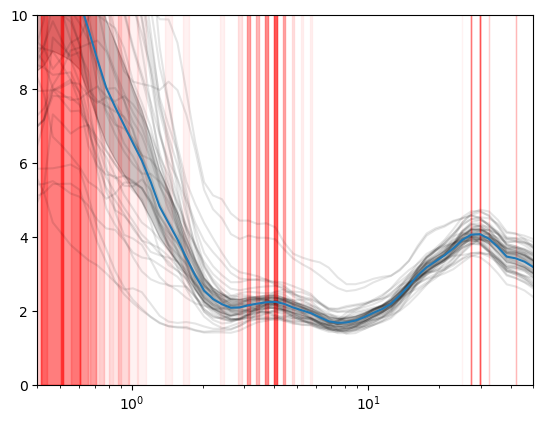

In [4]:
for t in hvsr_calc['ind_hvsr_curves']:
    plt.plot(hvsr_calc['x_freqs']['EHZ'][:-1],t, color='k', alpha=0.1)
plt.plot(hvsr_calc['x_freqs']['EHZ'][:-1],hvsr_calc['hvsr_curve'])
plt.fill_between(hvsr_calc['x_freqs']['EHZ'][:-1], hvsr_calc['hvsrm2'], hvsr_calc['hvsrp2'], color='k', alpha=0.2)
for t in hvsr_calc['ind_hvsr_peak_indices']:
    for v in t:
        v= hvsr_calc['x_freqs']['EHZ'][v]
        plt.fill_betweenx([0,50],v-0.05,v+0.05, color='r', alpha=0.05)
plt.semilogx()
plt.xlim([0.4,50])
plt.ylim([0,10])

In [5]:
hvsr_calc.keys()

dict_keys(['x_freqs', 'hvsr_curve', 'x_period', 'psd_values', 'psd_raw', 'ppsd_std', 'ppsd_std_vals_m', 'ppsd_std_vals_p', 'method', 'site', 'ppsds', 'ind_hvsr_curves', 'ind_hvsr_stdDev', 'ind_hvsr_peak_indices', 'hvsr_peak_indices', 'hvsr_log_std', 'peak_water_level', 'peak_water_level_p', 'peak_water_level_m', 'hvsrp', 'hvsrm', 'hvsrp2', 'hvsrm2'])

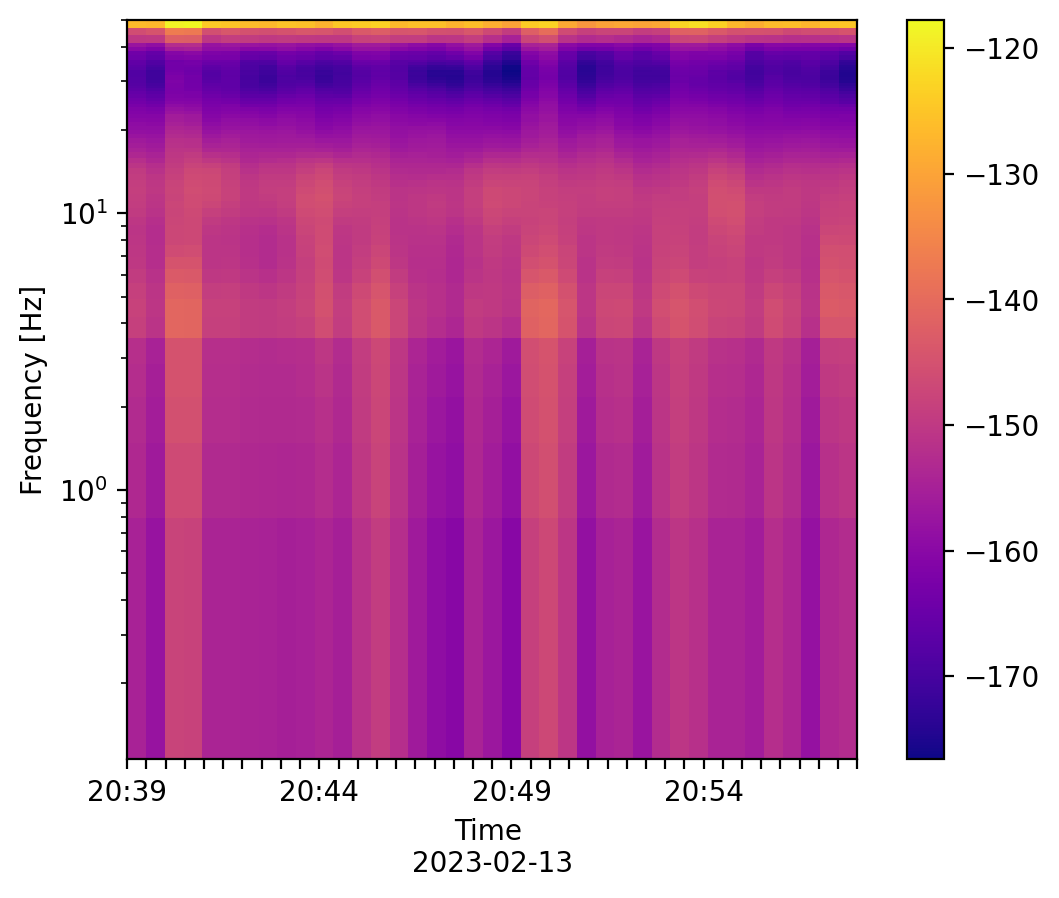

In [ ]:
import matplotlib.dates as mdates

psdList =[]
for k in hvsr_calc['psd_raw']:
    psdList.append(hvsr_calc['psd_raw'][k])
psdArr = np.array(psdList)
psdArr = np.mean(psdArr, axis=0)

xmin = datetime.datetime.strptime(min(ppsds['EHZ'].current_times_used).isoformat(), '%Y-%m-%dT%H:%M:%S.%f')
xmax = datetime.datetime.strptime(max(ppsds['EHZ'].current_times_used).isoformat(), '%Y-%m-%dT%H:%M:%S.%f')
xmin = mdates.date2num(xmin)
xmax = mdates.date2num(xmax)

tTicks = []
tLabels = []
for i, t in enumerate(ppsds['EHZ'].current_times_used):
    t1 = datetime.datetime.strptime(t.isoformat(), '%Y-%m-%dT%H:%M:%S.%f')
    tTicks.append(mdates.date2num(t1))
    day = str(t.date)
    if i%10==0:
        tLabels.append(str(t.hour)+':'+str(t.minute))
    else:
        tLabels.append('') 
extList = [xmin,xmax,min(hvsr_calc['x_freqs']['EHZ']),max(hvsr_calc['x_freqs']['EHZ'])]

plt.imshow(psdArr.T, origin='lower', extent=extList,aspect=.005, cmap='plasma')

FreqTicks = np.arange(1,np.round(max(hvsr_calc['x_freqs']['EHZ']),0), 10)
plt.xticks(ticks=tTicks, labels=tLabels)
#plt.yticks(np.round(hvsr_calc['x_freqs']['EHZ'],0))
plt.yticks(FreqTicks)
plt.xlabel('Time \n'+day)
plt.ylabel('Frequency [Hz]')
plt.semilogy()
plt.colorbar()
plt.rcParams['figure.dpi'] = 200
plt.show()

## Obspy

In [ ]:
sdList = []
for cSD in hvsr_calc['stDev']:
    sdList.append(cSD)
    print(cSD
          )
sdArr = np.array(sdList)
sdArr = np.mean(sdArr, axis=0)
sdArr

UFuncTypeError: ufunc 'add' did not contain a loop with signature matching types (dtype('<U3'), dtype('<U3')) -> None

In [ ]:
npRaw = np.array(ppsds['EHE'].psd_values).T

stDev = np.std(np.array(ppsds['EHE'].psd_values), axis=0)


numer = []
denom = 0
for f in npRaw:
    n = npRaw.size
    S = np.std(f)**2
    numer.append((n-1)*S)
    denom = denom+n
numer = np.array(numer)
denom = denom-npRaw.shape[0]
ans = np.sqrt(np.sum(numer)/denom)

11.121136011868774

In [ ]:
sigmaC = np.sum(npRaw**2, axis=1)
n = npRaw.shape[1]
Xc = np.mean(npRaw)**2
nc = npRaw.size
for i, n_ in sigmaC:
    sigmaC[i]

73

In [ ]:
len(hvsr_calc['hvsr_curve'])

72

In [ ]:
ppsds['EHZ'].psd_values[0].shape

(73,)

In [ ]:
ppsds['EHZ'].period_bin_centers.shape

(73,)

In [ ]:
kind='HVSR+-S'
if "HVSR" in kind:
    print(True)

True


In [ ]:
hvsr_calc

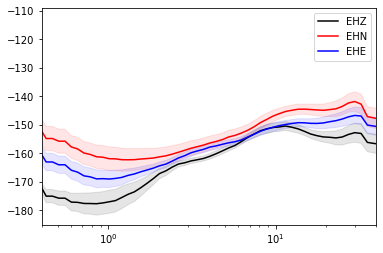

In [ ]:
hvsr.__check_xvalues(ppsds)

for k in ppsds:
    
    x_freqs = np.divide(np.ones_like(ppsds[k].period_bin_centers), ppsds[k].period_bin_centers)
    x_periods = np.array(ppsds[k].period_bin_centers)

    y = np.mean(np.array(ppsds[k].psd_values), axis=0)

x_freqs = {}
x_periods = {}

y = {}
stDev = {}
stDevVals = {}
for k in ppsds:
    
    x_freqs[k] = np.divide(np.ones_like(ppsds[k].period_bin_centers), ppsds[k].period_bin_centers)
    x_periods[k] = np.array(ppsds[k].period_bin_centers)

    y[k] = np.mean(np.array(ppsds[k].psd_values), axis=0)

    stDev[k] = np.std(np.array(ppsds[k].psd_values), axis=0)
    stDevVals[k] = np.array(y[k] - stDev[k])
    stDevVals[k]=np.stack([stDevVals[k], (y[k] + stDev[k])])
    if k == 'EHZ':
        pltColor = 'k'
    elif k =='EHE':
        pltColor = 'b'
    elif k == 'EHN':
        pltColor = 'r'
    
    plt.plot(x_freqs[k], y[k], c=pltColor, label=k)
    plt.fill_between(x_freqs[k], stDevVals[k][0], stDevVals[k][1], color=pltColor, alpha=0.1)
    #plt.plot(x_freqs[k], stDevVals[k][0], color='k', alpha=0.5)
    #plt.plot(x_freqs[k], stDevVals[k][1], color='k', alpha=0.5)
    plt.legend()
    plt.semilogx()
    plt.xlim([0.4,40])

In [ ]:
y = np.mean(np.array(ppsd.psd_values), axis=0)
x = np.array(ppsd.period_bin_centers)
plt.plot(x, y)
plt.semilogx()
plt.xlim([0,40])

NameError: name 'ppsd' is not defined

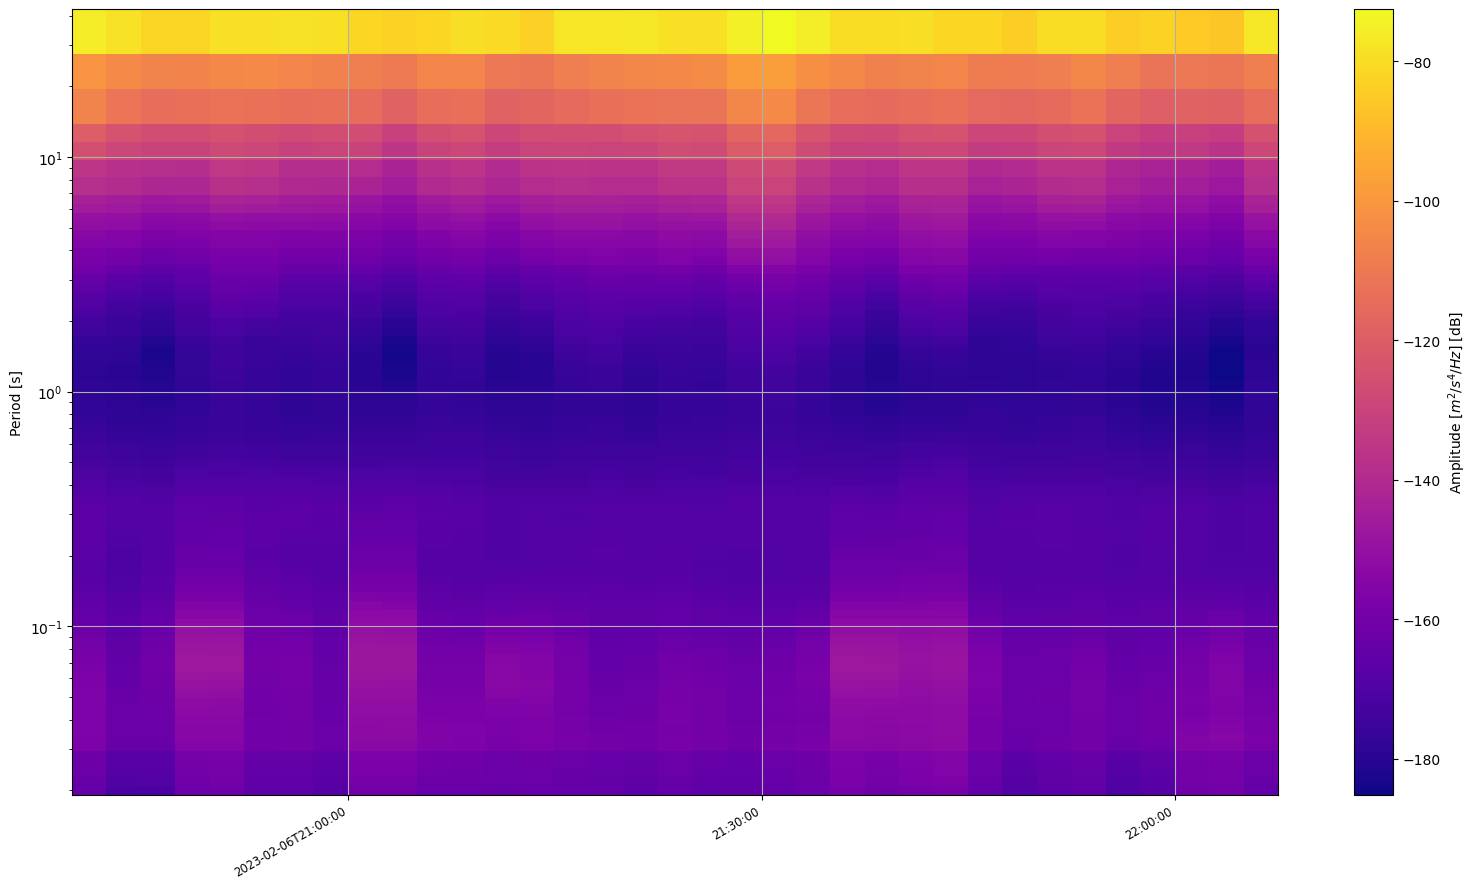

In [ ]:
ppsd.plot_spectrogram(cmap='plasma',show=True)
#plt.show()

## Matplotlib

In [ ]:
utcTime = stream[0].times(type='utcdatetime')

In [ ]:
trz = obspy.read(rC:\Users\riley\OneDrive - University of Illinois - Urbana\Data_OneDrive\Seismic\HVSR\RaspPiDataTest\RAC84\EHZ.D\AM.RAC84.00.EHZ.D.2023.037")
trn = obspy.read(r"C:\Users\riley\OneDrive - University of Illinois - Urbana\Data_OneDrive\Seismic\HVSR\RaspPiDataTest\RAC84\EHN.D\AM.RAC84.00.EHN.D.2023.037")
tre = obspy.read(r"C:\Users\riley\OneDrive - University of Illinois - Urbana\Data_OneDrive\Seismic\HVSR\RaspPiDataTest\RAC84\EHE.D\AM.RAC84.00.EHE.D.2023.037")

bpFilt = [0.01, 0.02, 15, 20]

trz = trz[0].remove_response(inventory=inv, pre_filt=bpFilt)
trn = trn[0].remove_response(inventory=inv, pre_filt=bpFilt)
tre = tre[0].remove_response(inventory=inv, pre_filt=bpFilt)

traceList = [trz, trn, tre]
st = obspy.Stream(traceList)

c:\Users\riley\.conda\envs\seismic38\lib\site-packages\obspy\core\inventory\network.py:249: UserWarning: Found more than one matching response. Returning first.
  warnings.warn(msg)


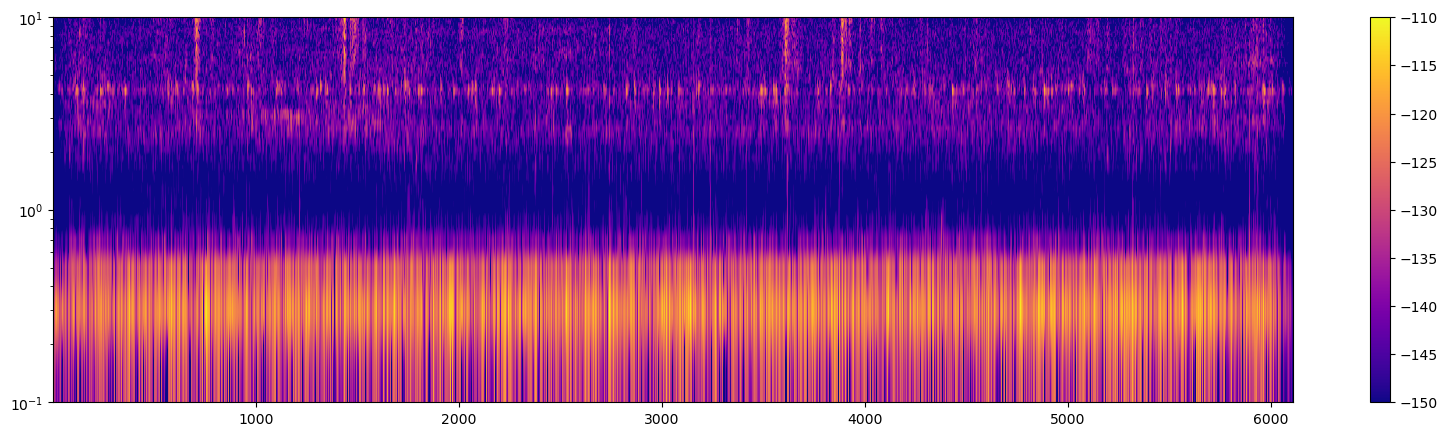

In [ ]:
plt.rcParams['figure.figsize']=(20,5)

spectrume, freqse, te, ime = plt.specgram(tre, Fs=100, detrend='mean', scale='dB', NFFT=512, noverlap=200, vmin=-150, vmax=-120, cmap='plasma')
spectrumn, freqsn, tn, imn = plt.specgram(trz, Fs=100, detrend='mean', scale='dB', NFFT=512, noverlap=200, vmin=-150, vmax=-120, cmap='plasma')
spectrumz, freqsz, tz, imz = plt.specgram(trz, Fs=100, detrend='mean', scale='dB', NFFT=512, vmin=-150, vmax=-110, cmap='plasma')
plt.ylim([0.1, 10])
plt.semilogy()
plt.colorbar()

(0.1, 10)

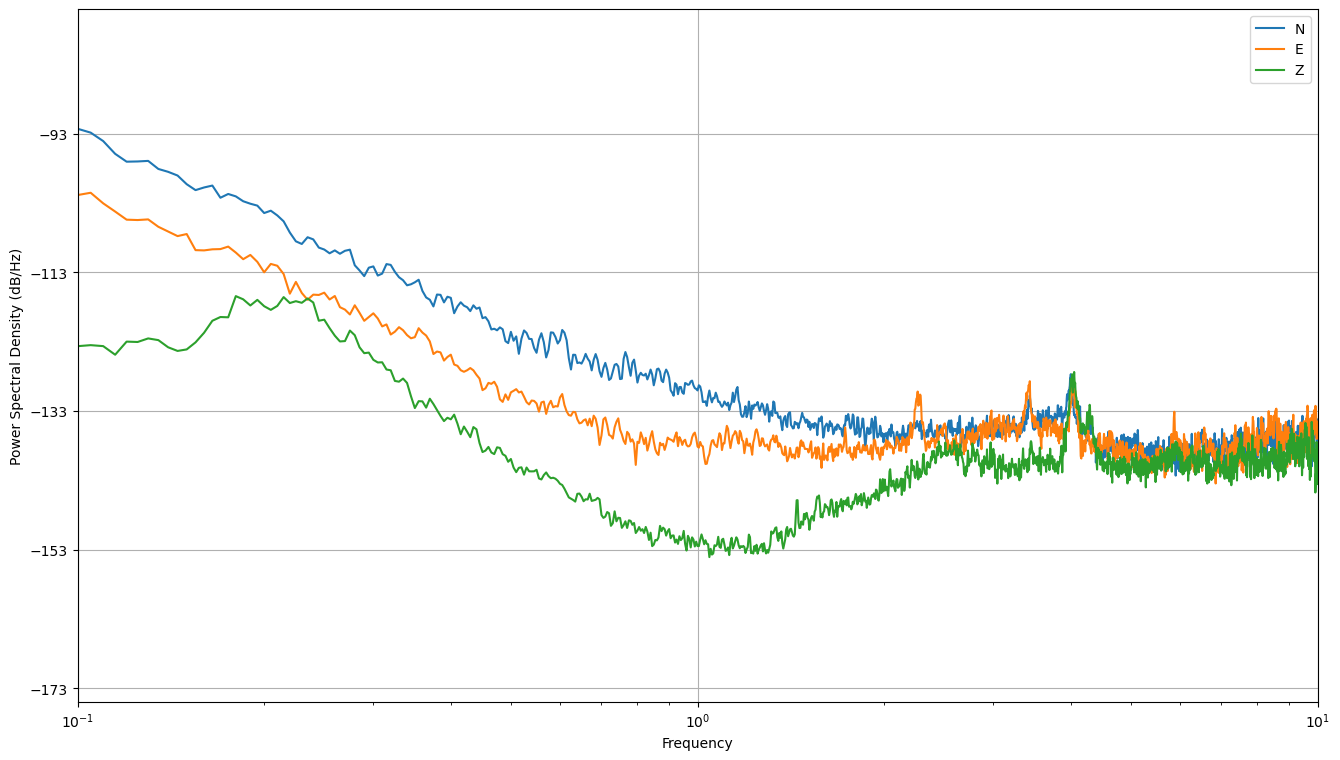

In [ ]:

pxxn, freqsn = plt.psd(trn, detrend='linear', Fs=100, NFFT=20000, return_line=False, label='N', noverlap=30, scale_by_freq=True)
pxxe, freqse = plt.psd(tre, detrend='linear', Fs=100, NFFT=20000, return_line=False, label='E', noverlap=30, scale_by_freq=True)
pxxz, freqsz = plt.psd(trz, detrend='linear', Fs=100, NFFT=20000, return_line=False, label='Z', noverlap=30, scale_by_freq=True)
plt.rcParams['figure.figsize'] = (16,9)
plt.legend()
plt.semilogx()
plt.ylim([-175, -75])
plt.xlim([0.1, 10])

(0.0, 1.0)

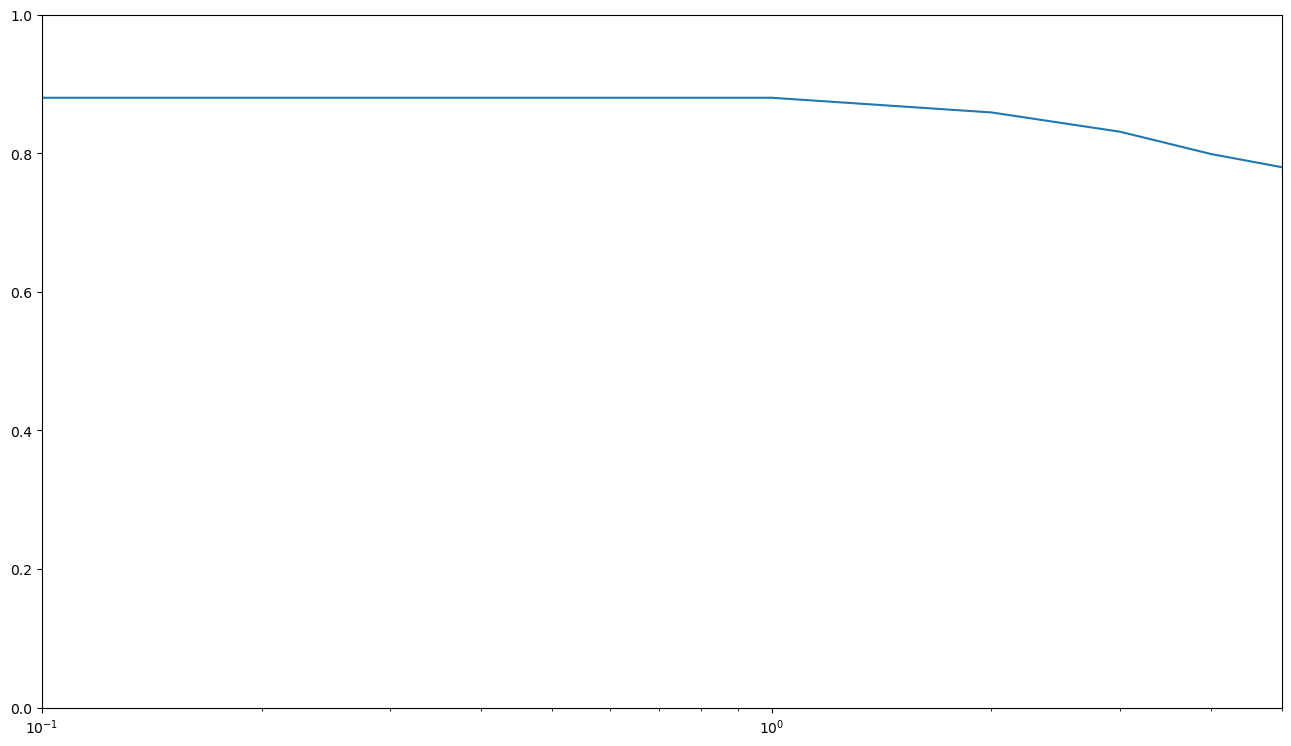

In [ ]:
H = np.mean(np.array([10*np.log(pxxn), 10*np.log(pxxe)]), axis=0)
HV = np.divide(H, 10*np.log(pxxz))
plt.plot(HV)
plt.semilogx()
plt.xlim([0.1,5])
plt.ylim([0,1])

(0.0, 30.0)

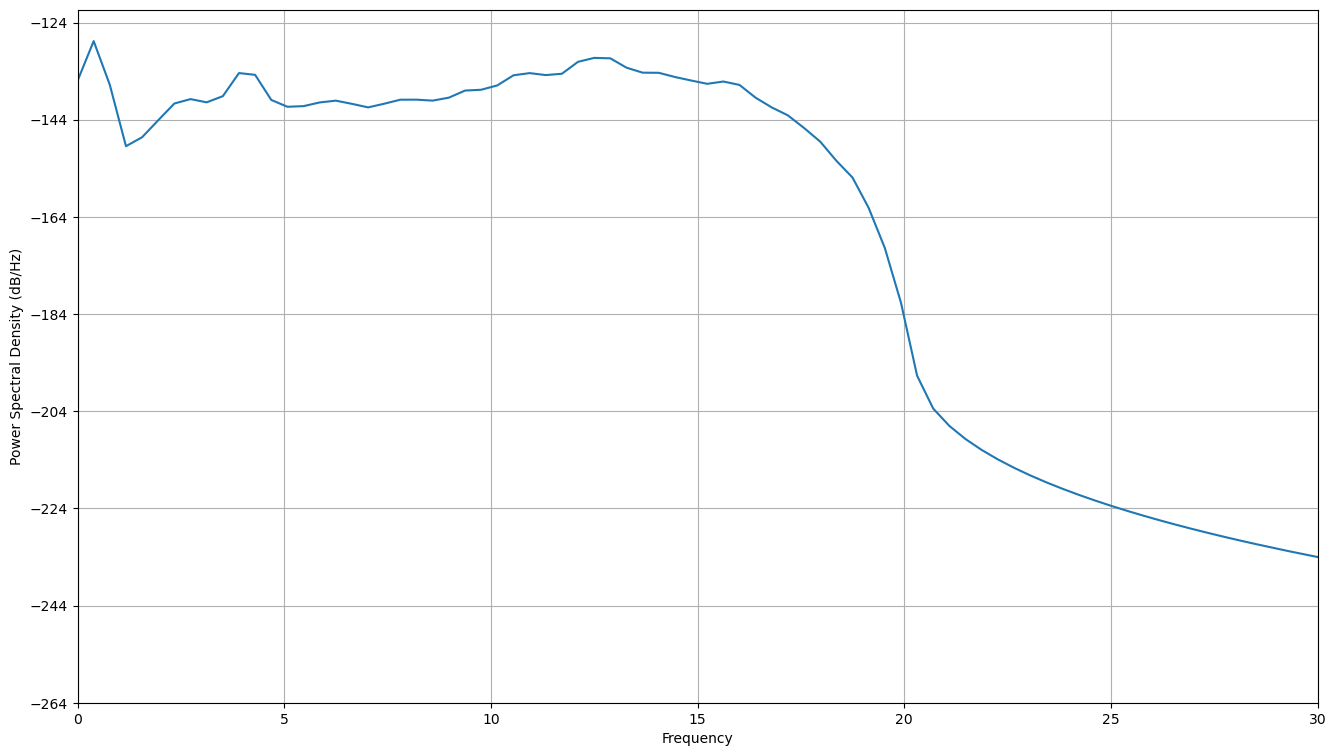

In [ ]:
pxx, freqs = plt.psd(trz, detrend='constant', Fs=100, return_line=False)
plt.xlim([0,30])

# HVSR

- (2) arithmetic mean, that is, H ≡ (HN + HE)/2
- (3) geometric mean, that is, H ≡ √HN · HE, recommended by the SESAME project (2004)
- (4) vector summation, that is, H ≡ √H2 N + H2 E
- (5) quadratic mean, that is, H ≡ √(H2 N + H2 E )/2
- (6) maximum horizontal value, that is, H ≡ max {HN, HE}

In [ ]:
def __get_hvsr(_dbz, _db1, _db2, _x, use_method=4):
    """
    H is computed based on the selected use_method see: https://academic.oup.com/gji/article/194/2/936/597415
        use_method:
           (1) DFA
           (2) arithmetic mean, that is, H ≡ (HN + HE)/2
           (3) geometric mean, that is, H ≡ √HN · HE, recommended by the SESAME project (2004)
           (4) vector summation, that is, H ≡ √H2 N + H2 E
           (5) quadratic mean, that is, H ≡ √(H2 N + H2 E )/2
           (6) maximum horizontal value, that is, H ≡ max {HN, HE}
    """
    _pz = get_power(_dbz, _x)
    _p1 = get_power(_db1, _x)
    _p2 = get_power(_db2, _x)
    #_dx = np.diff(_x)[0]

    #_pz = np.mean(_dbz)
    #_p1 = np.mean(_db1)
    #_p2 = np.mean(_db2)

    #_pz = _dbz #powspecdens.get_power(_dbz, _x)
    #_p1 = _db1 #powspecdens.get_power(_db1, _x)
    #_p2 = _db2 #powspecdens.get_power(_db2, _x)

    _hz = math.sqrt(_pz)
    _h1 = math.sqrt(_p1)
    _h2 = math.sqrt(_p2)

    _h = {  2: (_h1 + _h2) / 2.0, 
            3: math.sqrt(_h1 * _h2), 
            4: math.sqrt(_p1 + _p2), 
            5: math.sqrt((_p1 + _p2) / 2.0),
            6: max(_h1, _h2)}

    _hvsr = _h[use_method] / _hz
    return _hvsr

def remove_db(_db_value):
    """convert dB power to power"""
    _values = list()
    for _d in _db_value:
        _values.append(10 ** (float(_d) / 10.0))
    return _values


def get_power(_db, _x):
    """calculate HVSR
      We will undo setp 6 of MUSTANG processing as outlined below:
          1. Dividing the window into 13 segments having 75% overlap
          2. For each segment:
             2.1 Removing the trend and mean
             2.2 Apply a 10% sine taper
             2.3 FFT
          3. Calculate the normalized PSD
          4. Average the 13 PSDs & scale to compensate for tapering
          5. Frequency-smooth the averaged PSD over 1-octave intervals at 1/8-octave increments
          6. Convert power to decibels

    NOTE: PSD is equal to the power divided by the width of the bin
          PSD = P / W
          log(PSD) = Log(P) - log(W)
          log(P) = log(PSD) + log(W)  here W is width in frequency
          log(P) = log(PSD) - log(Wt) here Wt is width in period

    for each bin perform rectangular integration to compute power
    power is assigned to the point at the begining of the interval
         _   _
        | |_| |
        |_|_|_|

     Here we are computing power for individual ponts, so, no integration is necessary, just
     compute area
    """
    #print(_db)
    _dx = abs(np.diff(_x)[0])
    print(_dx)
    #_p = np.mean(remove_db(_db))
    _p = np.multiply(np.mean(remove_db(_db)), _dx)
    #print(_p)
    return _p

In [ ]:
method=4
hvsr_tmp = []
for j in range(len(x_freqs['EHE'])-1):
    psd0 = [y['EHZ'][j], y['EHZ'][j + 1]]
    psd1 = [y['EHE'][j], y['EHE'][j + 1]]
    psd2 = [y['EHN'][j], y['EHN'][j + 1]]
    f =    [x_freqs['EHZ'][j], x_freqs['EHZ'][j + 1]]

    #hvsr0 = get_hvsr(psd0, psd1, psd2, f, use_method=method)
    hvsr = __get_hvsr(psd0, psd1, psd2, f, use_method=4)

    hvsr_tmp.append(hvsr)

4.149797839766443
4.149797839766443
4.149797839766443
3.8053813975478334
3.8053813975478334
3.8053813975478334
3.489550127487213
3.489550127487213
3.489550127487213
3.1999315758711475
3.1999315758711475
3.1999315758711475
2.93435019305214
2.93435019305214
2.93435019305214
2.6908109912072113
2.6908109912072113
2.6908109912072113
2.4674845584365848
2.4674845584365848
2.4674845584365848
2.262693316631438
2.262693316631438
2.262693316631438
2.0748989198832213
2.0748989198832213
2.0748989198832213
1.9026906987739167
1.9026906987739167
1.9026906987739167
1.7447750637436066
1.7447750637436066
1.7447750637436066
1.5999657879355702
1.5999657879355702
1.5999657879355702
1.4671750965260664
1.4671750965260664
1.4671750965260664
1.3454054956036092
1.3454054956036092
1.3454054956036092
1.2337422792182888
1.2337422792182888
1.2337422792182888
1.1313466583157226
1.1313466583157226
1.1313466583157226
1.0374494599416089
1.0374494599416089
1.0374494599416089
0.9513453493869601
0.9513453493869601
0.951345

(0.4, 40)

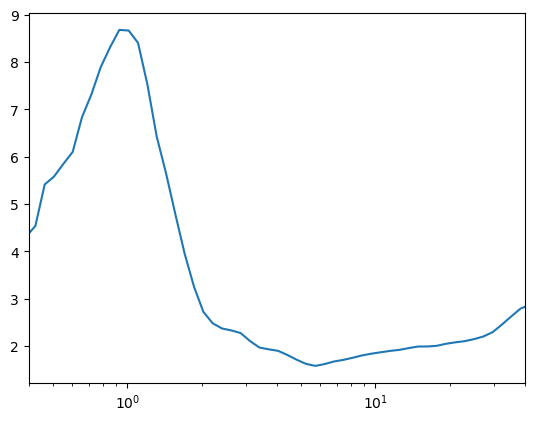

In [ ]:
plt.plot(x_freqs['EHZ'][:-1], hvsr_tmp)
plt.semilogx()
plt.xlim([0.4, 40])

(0.3, 10)

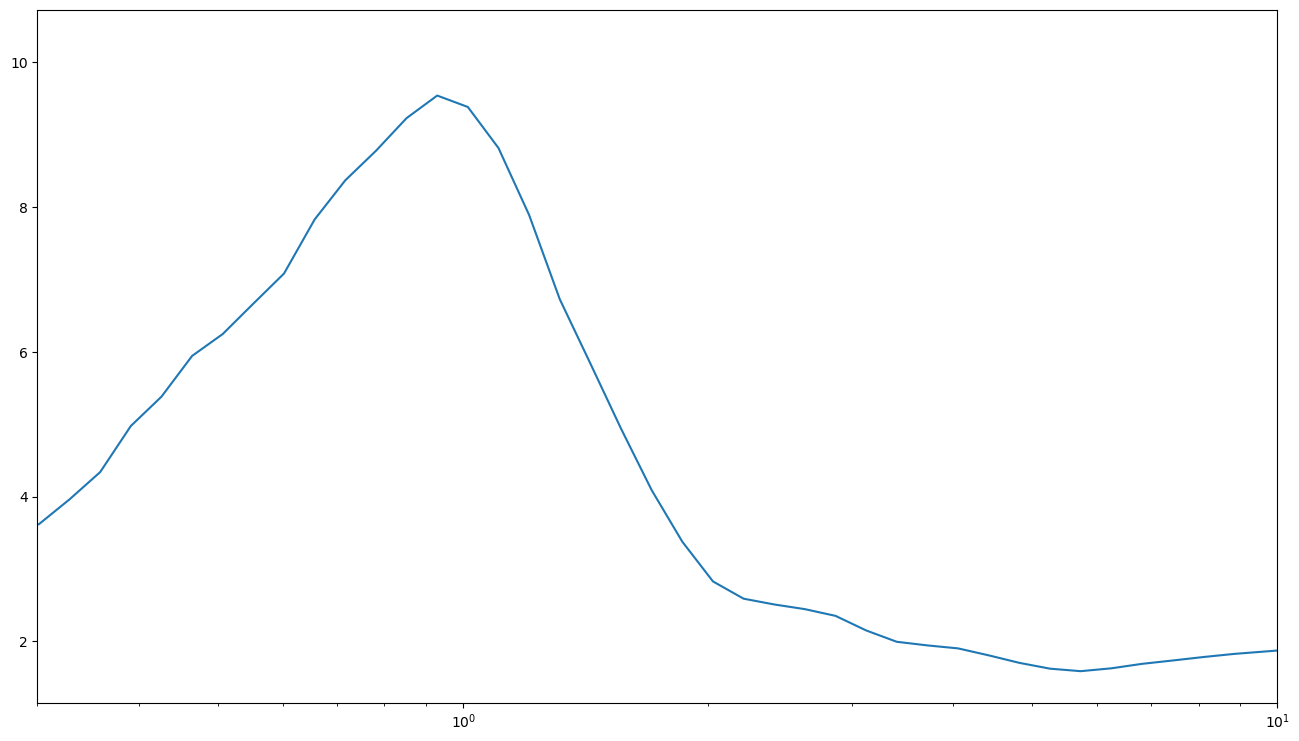

In [ ]:
plt.plot(freqsX[:-1],hvsr_tmp)
plt.semilogx()
plt.xlim([0.3, 10])